In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
 
import os
 
import sys
 
import seaborn as sns

print(sns.__version__)  #ideally 0.9.0

0.9.0


In [2]:
ROOT_DIR = "/home/charles/Projects/Plaques"
sys.path.append(os.path.join(ROOT_DIR, "Python"))  

In [3]:
#Import this module
from OsmnxStreets import *

In [4]:
#Read in the different unique streets
dfStreetEdges=getDfStreetEdges()
dfStreetEdges.head(2)

index               Street   lngStart   latStart     lngEnd     latEnd
0      0  rue Wilfrid-Laurier -71.211626  46.808025 -71.222580  46.801753
1      1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131

In [5]:
#Get the graph
graphQcReduced =getQcGraphSubnetCentroidBbox(bufferKm=1)

In [6]:
#Check within bbox
dfBbox=getHardCodedSJB_SaintRoch_VieuxQcBbox_4ExtremePoints()
checkBoxAll(dfStreetEdges,dfBbox)

True

In [7]:
#Add nodes
numNodesBefore=len(graphQcReduced.nodes())
graph,dfNodesWithIndex= addNodesGraph(graphQcReduced,dfStreetEdges)
numNodesAfter=len(graphQcReduced.nodes())
newNodes=(numNodesAfter-numNodesBefore)
newNodes

removed 1 duplicate rows:
    index                  Street   lngStart   latStart     lngEnd    latEnd
9     10  rue Saint-Jean vieuxqc -71.215778  46.812134 -71.209147  46.81464 
There are  89 unique nodes


89

In [8]:
#Add distances (need the correct node indices => this is shitty code)
dfStreetEdgesWithDist=addStreetDistances(dfStreetEdges,dfNodesWithIndex) 
dfStreetEdgesWithDist.head(2)

index_x               Street   lngStart   latStart     lngEnd     latEnd  \
0        0  rue Wilfrid-Laurier -71.211626  46.808025 -71.222580  46.801753   
1        1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131   

     idxStart      lng_x      lat_x      idxEnd      lng_y      lat_y  \
0  6336677178 -71.211626  46.808025  6336677223 -71.222580  46.801753   
1  6336677179 -71.228938  46.807552  6336677224 -71.220098  46.812131   

      distance  
0  1242.840335  
1   999.974438

In [9]:
#Add the neighbourhood
dfPlaques=pd.read_csv(os.path.join(ROOT_DIR,"Data","Csv","NoLngLat", "AllNeighbourhoods" , "plaquesTidy.csv"),delimiter=",")
dfStreetEdgesWithNeighDist = pd.merge(dfStreetEdgesWithDist, dfPlaques, on="Street", how="left" )
dfStreetEdgesWithNeighDist.head()

index_x               Street   lngStart   latStart     lngEnd     latEnd  \
0        0  rue Wilfrid-Laurier -71.211626  46.808025 -71.222580  46.801753   
1        1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131   
2        1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131   
3        3    rue Saint-Gabriel -71.218576  46.810208 -71.222092  46.808695   
4        4         rue Aberdeen -71.228321  46.801381 -71.225280  46.803173   

     idxStart      lng_x      lat_x      idxEnd      lng_y      lat_y  \
0  6336677178 -71.211626  46.808025  6336677223 -71.222580  46.801753   
1  6336677179 -71.228938  46.807552  6336677224 -71.220098  46.812131   
2  6336677179 -71.228938  46.807552  6336677224 -71.220098  46.812131   
3  6336677180 -71.218576  46.810208  6336677225 -71.222092  46.808695   
4  6336677181 -71.228321  46.801381  6336677226 -71.225280  46.803173   

      distance                Name                  Address  \
0  1242.840335      Alleyn, Edmund  85, rue Wilfrid-Laurier   
1   999.974438       Angers, Henri  166, rue de la Tourelle   
2   999.974438  Sauvageau, Wilfrid  534, rue de la Tourelle   
3   396.056662   Belley, Henriette   559, rue Saint-Gabriel   
4   345.362076     Blatter, Robert         49, rue Aberdeen   

       Neighbourhood           Borough  
0  SaintJeanBaptiste  La Cité-Limoilou  
1  SaintJeanBaptiste  La Cité-Limoilou  
2  SaintJeanBaptiste  La Cité-Limoilou  
3  SaintJeanBaptiste  La Cité-Limoilou  
4  SaintJeanBaptiste  La Cité-Limoilou

In [10]:
#Fix some bullshit with rue st-jean
idxSJB=~np.isin( [ re.match("rue Saint-Jean sjb", s) for s in  dfStreetEdgesWithDist["Street"]],  None)
distStJeanSJB=dfStreetEdgesWithDist.loc[idxSJB , "distance"].values[0]

idxVieuxQc=~np.isin( [ re.match("rue Saint-Jean vieu*.", s) for s in  dfStreetEdgesWithDist["Street"]],  None)
distStJeanVieuxQc=dfStreetEdgesWithDist.loc[idxVieuxQc, "distance" ].values[0]



idxSJB2=~np.isin( [ re.match("rue Saint-Jean sjb", s) for s in  dfStreetEdgesWithNeighDist["Street"]],  None)
dfStreetEdgesWithNeighDist.loc[idxSJB2 , "distance"]= distStJeanSJB
dfStreetEdgesWithNeighDist.at[idxSJB2 , "Neighbourhood"]= "SaintJeanBaptiste"

idxVieuxQc2=~np.isin( [ re.match("rue Saint-Jean vieu*.", s) for s in  dfStreetEdgesWithNeighDist["Street"]],  None)
dfStreetEdgesWithNeighDist.loc[idxVieuxQc2 , "distance"]= distStJeanVieuxQc
dfStreetEdgesWithNeighDist.at[idxVieuxQc2, "Neighbourhood"]= "VieuxQuebec"

In [11]:
#Add edges
numEdgesBefore=len(graphQcReduced.edges())
addEdgesGraph(graphQcReduced,dfStreetEdgesWithNeighDist)
numEdgesAfter=len(graphQcReduced.edges)
numEdgesAfter-numEdgesBefore

Added 45  edges to the graph


45

In [13]:
#[ dat[2] for k, dat in enumerate(graphQcReduced.edges.data()) if k >= numEdgesBefore+7]

In [18]:
dictCol={}
dictCol["SaintJeanBaptiste"] ="black"
dictCol["VieuxQuebec"] ="blue"
dictCol["SaintRoch"] ="green"

def getCol(s):
    
    try:
        col=dictCol[s]
    except :
        col="grey"
        
    return (col)

In [35]:
df=pd.DataFrame.from_items( [  ( "neigh" , [    dat[2]['neighbourhood'] for k, dat in enumerate(graphQcReduced.edges.data()) if k >= numEdgesBefore+1]) ])
df["Street"]=[   dat[2]['name']  for k, dat in enumerate(graphQcReduced.edges.data()) if k >= numEdgesBefore+1]
df["col"]=[   getCol(dat[2]['neighbourhood'])  for k, dat in enumerate(graphQcReduced.edges.data()) if k >= numEdgesBefore+1]
df

/home/charles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


neigh                           Street    col
0   SaintJeanBaptiste        custom_rue de la Tourelle  black
1   SaintJeanBaptiste         custom_rue Saint-Gabriel  black
2   SaintJeanBaptiste              custom_rue Aberdeen  black
3   SaintJeanBaptiste             custom_rue Richelieu  black
4   SaintJeanBaptiste         custom_rue Saint-Olivier  black
5   SaintJeanBaptiste          custom_rue De Bernières  black
6   SaintJeanBaptiste           custom_rue D’Aiguillon  black
7   SaintJeanBaptiste        custom_rue Saint-Jean sjb  black
8         VieuxQuebec    custom_rue Saint-Jean vieuxqc   blue
9   SaintJeanBaptiste              custom_rue Lockwell  black
10  SaintJeanBaptiste                custom_rue Burton  black
11  SaintJeanBaptiste            custom_côte d’Abraham  black
12  SaintJeanBaptiste       custom_rue Philippe-Dorval  black
13  SaintJeanBaptiste                 custom_rue Scott  black
14  SaintJeanBaptiste          custom_Grande-Allée Est  black
15  SaintJeanBaptiste              custom_rue Turnbull  black
16          SaintRoch                custom_rue du Roi  green
17          SaintRoch             custom_avenue Daulac  green
18          SaintRoch    custom_rue Saint-François Est  green
19          SaintRoch  custom_rue De Saint-Vallier Est  green
20          SaintRoch            custom_rue Dorchester  green
21          SaintRoch      custom_rue Saint-Joseph Est  green
22          SaintRoch             custom_rue du Parvis  green
23          SaintRoch  custom_rue Notre-Dame-des-Anges  green
24        VieuxQuebec               custom_rue Ferland   blue
25        VieuxQuebec             custom_rue Couillard   blue
26        VieuxQuebec            custom_côte du Palais   blue
27        VieuxQuebec            custom_rue du Parloir   blue
28        VieuxQuebec           custom_rue de la Porte   blue
29        VieuxQuebec             custom_rue D’Auteuil   blue
30        VieuxQuebec            custom_rue Saint-Paul   blue
31        VieuxQuebec                custom_rue Hébert   blue
32        VieuxQuebec           custom_rue Mont-Carmel   blue
33        VieuxQuebec           custom_rue Sainte-Anne   blue
34        VieuxQuebec          custom_rue Saint-Ursule   blue
35        VieuxQuebec          custom_rue des Remparts   blue
36        VieuxQuebec  custom_rue Monseigneur-De-Laval   blue
37        VieuxQuebec        custom_rue Sainte-Famille   blue
38        VieuxQuebec           custom_rue des Grisons   blue
39        VieuxQuebec       custom_rue Saint-Stanislas   blue
40        VieuxQuebec         custom_rue Sainte-Ursule   blue
41        VieuxQuebec           custom_rue Saint-Louis   blue
42        VieuxQuebec   custom_avenue Sainte-Geneviève   blue
43        VieuxQuebec              custom_rue Christie   blue

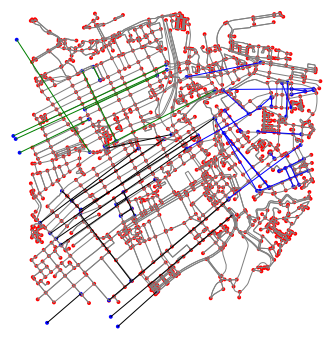

In [39]:
#Plot the new graph
newColMap = [  "r" for k in range(1552) ] + ["b" for k in range(newNodes)]
#newColMapEdges = [  "grey" for k in range(numEdgesBefore) ] + ["b" for k in range(numEdgesAfter-numEdgesBefore)]
newColMapEdges = [  "grey" for k in range(numEdgesBefore) ] + [ getCol ( dat[2]["neighbourhood"] ) for k, dat in enumerate(graphQcReduced.edges.data()) if k >= numEdgesBefore]

fig, ax =ox.plot_graph(graphQcReduced,
              node_color=newColMap,
              edge_color=newColMapEdges ,
              save =True,
              filename="qcGraphWithEdges.png",
              file_format="png"
             )

In [42]:
os.getcwd()
os.listdir('../Data/GeoData/Neighbourhoods/' )

['vdq-quartier.prj',
 'vdq-quartier.dbf',
 '.gitkeep',
 'vdq-quartier.shp',
 'vdq-quartier.shx']

In [43]:
#Read the neighbourhood shape file

qcCityNeigh = gpd.read_file('../Data/GeoData/Neighbourhoods/vdq-quartier.shp')
listNeighbourhoods=["Saint-Jean-Baptiste" , "Saint-Roch", "Vieux-Québec/Cap-Blanc/Colline parlementaire"]
qcCityThreeNeigh=qcCityNeigh[ np.isin( qcCityNeigh.NOM ,listNeighbourhoods ) ].reset_index()
 


In [44]:
#nodes, _ =  ox.graph_to_gdfs(graphQcReduced)
#type(nodes)

In [64]:
qcCityThreeNeigh.head(2)

index  ID                                           NOM  SUPERFICIE  \
0      0   1                           Saint-Jean-Baptiste   678906.19   
1      3   4  Vieux-Québec/Cap-Blanc/Colline parlementaire  4293772.29   

   PERIMETRE                                           geometry  
0    3781.17  POLYGON Z ((-71.21631942283598 46.812638240404...  
1   13796.73  POLYGON Z ((-71.20001449142366 46.813926919298...

In [72]:
colmappoly={} 
colmappoly["Saint-Jean-Baptiste"] ="black"
colmappoly["Vieux-Québec/Cap-Blanc/Colline parlementaire"] ="blue"
colmappoly["Saint-Roch"] ="green"
[ colmappoly[i] for i in  qcCityThreeNeigh["NOM"]]

['black', 'blue', 'green']

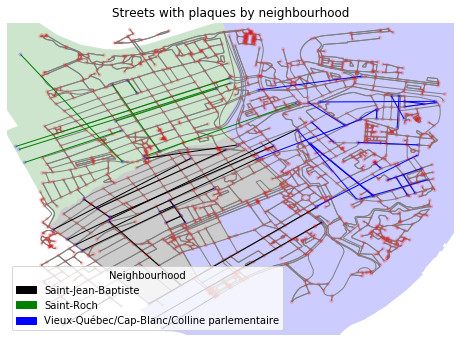

In [154]:
import matplotlib.patches as mpatches

#Put both in the same cell
fig, ax = ox.plot_graph(graphQcReduced, fig_height=12, fig_width=8, 
                        show=False, close=False, 
                         node_color=newColMap,
                        edge_color=newColMapEdges,
                        node_zorder=3,
                        node_alpha=0.2
                        )
listLegendHandles=[]
for nom, dat in qcCityThreeNeigh.groupby("NOM") :
    #Legend hack
    listLegendHandles.append(
        mpatches.Patch(color=colmappoly[nom], 
                   label=nom)
    )
                   
    col=colmappoly[nom]
    fig = dat.plot(
        legend=True,
        label=  nom,
        color=col,
        ax=ax,
        alpha=0.2)
      
    
plt.title("Streets with plaques by neighbourhood")
plt.legend(title="Neighbourhood",
           handles=listLegendHandles,
           loc="lower left")


plt.savefig("qcGraphWithEdgesAndNeighbourhoods.png")
plt.show()
 

In [ ]:
plt.savefig("bla.png")

In [84]:
#plt.subplot(1, 1, 1)
#fig, ax =ox.plot_graph(graphQcReduced,
#              node_color=newColMap,
#              edge_color=newColMapEdges ,
#              close=False
#             )
#plt.subplot(1, 2, 2)
 
#qcCityThreeNeigh.plot(column='NOM')
#plt.show()


[]

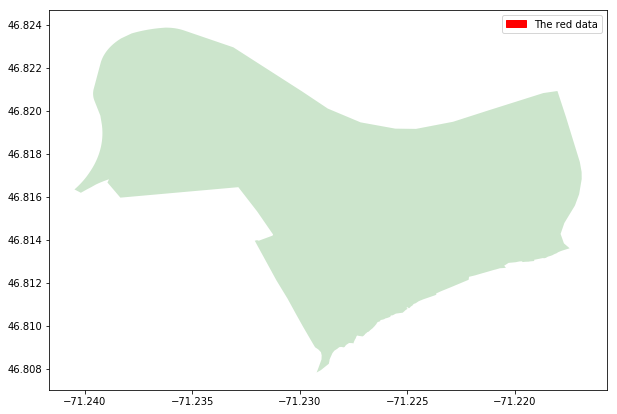

In [143]:

 
red_patch = mpatches.Patch(color='red', label='The red data')
plt.legend(handles=[red_patch])

In [ ]:

#Create 
listGraphs=[]
for k in range(qcCityThreeNeigh.shape[0]):
    listGraphs.append( ox.graph_from_polygon(qcCityThreeNeigh["geometry"].iloc[k], network_type='drive_service') )

In [13]:
getDistanceOSM(dfStreetEdgesWithDist, graphQcReduced)

There were  177615  errors in total trying to compute distance with osm edge attribute


{'rue Wilfrid-Laurier': 1225.3799999999999,
 'rue de la Tourelle': 857.313,
 'rue Saint-Gabriel': 321.26500000000004,
 'rue Aberdeen': 113.852,
 'rue Richelieu': 1363.8519999999999,
 'rue Saint-Olivier': 1028.1029999999998,
 'rue De Bernières': 0,
 'rue D’Aiguillon': 0,
 'rue Saint-Jean sjb': 1974.1530000000002,
 'rue Saint-Jean vieuxqc': 1974.1530000000002,
 'rue Lockwell': 468.416,
 'rue Burton': 175.666,
 'côte d’Abraham': 0,
 'rue Philippe-Dorval': 188.94299999999998,
 'rue Scott': 253.34,
 'Grande-Allée Est': 0,
 'rue Turnbull': 1158.9740000000002,
 'rue du Roi': 1052.313,
 'avenue Daulac': 210.052,
 'rue Saint-François Est': 706.661,
 'rue De Saint-Vallier Est': 1410.2939999999999,
 'rue Dorchester': 648.419,
 'rue Saint-Joseph Est': 868.226,
 'rue du Parvis': 992.6580000000001,
 'rue Notre-Dame-des-Anges': 439.606,
 'rue Ferland': 169.314,
 'rue Couillard': 233.176,
 'côte du Palais': 0,
 'rue du Parloir': 46.111999999999995,
 'rue de la Porte': 225.227,
 'rue D’Auteuil': 0,
 'r